## Building the protrusion tables

This notebook contains all the code needed to build the protrusion tables used in further analysis later. The protrusion tables needs to be atom based. In general, the table should contain CB's with its atom number & coordinates, the residue name & number, how many neighbours (other CA or CB) within 1nm there are, if the residue is part of the computed convex hull, if the residue is considered to be hydrophobic and the pdb name.

### 1) Imports & global stuff

In [2]:
import os
import pandas as pd
import numpy as np
from biopandas.pdb import PandasPdb
from scipy.spatial import ConvexHull
import scipy.spatial.distance as scidist

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import matplotlib.transforms as mtransforms
import seaborn as sns

import tqdm

In [3]:
DISTANCE = 10
DENSITY = 22
HYDROPHOBICS = ['LEU', 'ILE', 'PHE', 'TYR', 'TRP', 'CYS', 'MET']

### 2) Defining functions

In [9]:
def find_features_periph(pdb_name, atomTable):
    """
    This function find all features of interest and returns a table with the results
    """
    
    # Matrix for all atoms
    m = atomTable[["x_coord", "y_coord", "z_coord"]].to_numpy()

    # Compute convex hull
    hull = ConvexHull(m)

    # Compute distances
    distvector = scidist.pdist(m)
    dist = scidist.squareform(distvector)

    # Var's
    result = []
    
    # Cache
    atomNames = atomTable["atom_name"].to_numpy()
    residueNumbers = atomTable["residue_number"].to_numpy()
    residueNames = atomTable["residue_name"].to_numpy()
    chainIds = atomTable["chain_id"].to_numpy()
    atomNumbers = atomTable["atom_number"].to_numpy()
    xCoords = atomTable["x_coord"].to_numpy()
    yCoords = atomTable["y_coord"].to_numpy()
    zCoords = atomTable["z_coord"].to_numpy()
    
    
    # Do the magic
    for idx, row in enumerate(dist):
        
        # Atom has to be CB
        if atomNames[idx] == "CB":
            
            # Tmp var's to remember features
            onConvHull = 0; isProtrusion = 0; isHydrophobicProtrusion = 0
            neighbours = row[row < DISTANCE].shape[0] - 1
        
            # Atom has to be a convex hull vertex to become a protrusion
            if idx in hull.vertices:
                onConvHull = 1
            
                # Check for low density & mark as protrusion
                if neighbours < DENSITY:
                    isProtrusion = 1
                    
                    # Check if protrusion is hydrophobic
                    if residueNames[idx] in HYDROPHOBICS:
                        isHydrophobicProtrusion = 1

        
            # Collect features
            result.append({"pdb": pdb_name, "residue_number": residueNumbers[idx], "residue_name": residueNames[idx], "chain_id": chainIds[idx],
                           "atom_number": atomNumbers[idx], "atom_name": atomNames[idx], "x_coord": xCoords[idx], "y_coord": yCoords[idx],
                           "z_coord": zCoords[idx], "is_on_convhull": onConvHull, "neighbours": neighbours,"is_protrusion": isProtrusion,
                           "is_hydrophobic_protrusion": isHydrophobicProtrusion, "idx": idx, "is_co_insertable": 0})
            
    # Finding co_insertables
    hydr_prot = pd.DataFrame(result).query("is_hydrophobic_protrusion == 1")
    simplices = pd.DataFrame(hull.simplices, columns=["x","y","z"])
    co_insertable = []
    for residue in hydr_prot.iterrows():
        idx = residue[1]["idx"]
        dd = simplices.query(" (x == " + str(idx) + " or y == " + str(idx) + " or z == " + str(idx) + ")")
        uniques = np.unique(dd.values)
        uniques = uniques[uniques != idx]
        uniques = [x for x in uniques if x in hydr_prot["idx"].values]
        uniques = [x for x in uniques if dist[idx][x] < DISTANCE]
        co_insertable.extend(uniques)
    co_insertable = np.unique(co_insertable)

    # Collect 
    hydr_prot.loc[hydr_prot["idx"].isin(co_insertable), "is_co_insertable"] = 1
    hydr_prot = hydr_prot[hydr_prot["is_co_insertable"] > 0]
    for idx, row in enumerate(result):
        if row["idx"] in hydr_prot["idx"].values:
            row["is_co_insertable"] = 1
    
    # Return the result
    return result


def find_features_tm(pdb_name, pdb, atomTable):
    """
    This function find all features of interest and returns a table with the results
    """
    
    # Matrix for all atoms
    m = atomTable[["x_coord", "y_coord", "z_coord"]].to_numpy()

    # Compute convex hull
    hull = ConvexHull(m)

    # Compute distances
    distvector = scidist.pdist(m)
    dist = scidist.squareform(distvector)

    # Var's
    result = []
    
    # Cache
    atomNames = atomTable["atom_name"].to_numpy()
    residueNumbers = atomTable["residue_number"].to_numpy()
    residueNames = atomTable["residue_name"].to_numpy()
    chainIds = atomTable["chain_id"].to_numpy()
    atomNumbers = atomTable["atom_number"].to_numpy()
    xCoords = atomTable["x_coord"].to_numpy()
    yCoords = atomTable["y_coord"].to_numpy()
    zCoords = atomTable["z_coord"].to_numpy()
    
    # Find special stuff for tm
    dumTable = pdb.df["HETATM"].query("residue_name == 'DUM'")
    lower_membrane_limit = None; upper_membrane_limit = None
    additional_distance = 15
    
    if len(dumTable.query("atom_name == 'N'")) > 0:
        lower_membrane_limit = dumTable.query("atom_name == 'N'")["z_coord"].iloc[0] - additional_distance
    if len(dumTable.query("atom_name == 'O'")) > 0:
        upper_membrane_limit = dumTable.query("atom_name == 'O'")["z_coord"].iloc[0] + additional_distance
    
    
    # Do the magic
    for idx, row in enumerate(dist):
        
        # Atom has to be CB
        if atomNames[idx] == "CB":
            
            # Tmp var's to remember features
            onConvHull = 0; isProtrusion = 0; isHydrophobicProtrusion = 0
            neighbours = row[row < DISTANCE].shape[0] - 1
        
            # Atom has to be a convex hull vertex to become a protrusion
            if idx in hull.vertices:
                onConvHull = 1
            
                # Check for low density
                if neighbours < DENSITY:
                    
                    # Check if enough away from the hydrocarbon region & mark as protrusion
                    if lower_membrane_limit is not None and upper_membrane_limit is not None:
                        if zCoords[idx] < lower_membrane_limit or zCoords[idx] > upper_membrane_limit:
                            isProtrusion = 1
                    elif lower_membrane_limit is not None:
                        if zCoords[idx] < lower_membrane_limit:
                            isProtrusion = 1
                    elif upper_membrane_limit is not None:
                        if zCoords[idx] > upper_membrane_limit:
                            isProtrusion = 1
                    
                    # Check if protrusion is hydrophobic
                    if isProtrusion == 1 and residueNames[idx] in HYDROPHOBICS:
                        isHydrophobicProtrusion = 1

        
            # Collect features
            result.append({"pdb": pdb_name, "residue_number": residueNumbers[idx], "residue_name": residueNames[idx], "chain_id": chainIds[idx],
                           "atom_number": atomNumbers[idx], "atom_name": atomNames[idx], "x_coord": xCoords[idx], "y_coord": yCoords[idx],
                           "z_coord": zCoords[idx], "is_on_convhull": onConvHull, "neighbours": neighbours,"is_protrusion": isProtrusion,
                           "is_hydrophobic_protrusion": isHydrophobicProtrusion, "idx": idx, "is_co_insertable": 0, 
                           "l_limit": lower_membrane_limit, "u_limit": upper_membrane_limit})
            
    # Finding co_insertables
    hydr_prot = pd.DataFrame(result).query("is_hydrophobic_protrusion == 1")
    simplices = pd.DataFrame(hull.simplices, columns=["x","y","z"])
    co_insertable = []
    for residue in hydr_prot.iterrows():
        idx = residue[1]["idx"]
        dd = simplices.query(" (x == " + str(idx) + " or y == " + str(idx) + " or z == " + str(idx) + ")")
        uniques = np.unique(dd.values)
        uniques = uniques[uniques != idx]
        uniques = [x for x in uniques if x in hydr_prot["idx"].values]
        uniques = [x for x in uniques if dist[idx][x] < DISTANCE]
        co_insertable.extend(uniques)
    co_insertable = np.unique(co_insertable)

    # Collect 
    hydr_prot.loc[hydr_prot["idx"].isin(co_insertable), "is_co_insertable"] = 1
    hydr_prot = hydr_prot[hydr_prot["is_co_insertable"] > 0]
    for idx, row in enumerate(result):
        if row["idx"] in hydr_prot["idx"].values:
            row["is_co_insertable"] = 1
    
    # Return the result
    return result

In [4]:
def extract_atom_table(path):
    """
    This function extracts the atom table of a given pdb, returns just rows of CA and CB.
    :param path: Path to the pdb file
    """
    return PandasPdb().read_pdb(path)


def trim_and_filter(pdb):
    """
    This function trims & filters the atomTable for some properties and returns the final atomTable for analysis.
    This function is mainly for peripheral proteins.
    """
    
    # Get atom table
    atomTable = pdb.df["ATOM"]
    
    # Subset only CA & CB atoms
    atomTable = atomTable.query("atom_name in ['CA', 'CB']")
    
    # Trim for multiple alternate locations
    atomTable = atomTable.query("alt_loc in ['A', '']")
    
    # return witch clean indicies
    return atomTable.reset_index()


def readIDs(filepath):
    """
    Read / parse a text file containing pdb ID's

    :param filepath: The path to the file to parse / read
    :return: The list of pdb ID's parsed
    """
    id_list = []
    with open(filepath) as f:
        for line in f:
            id_list.append(line.replace("\n", ""))

    return id_list

### 3) Read the raw data & build the datasets / tables

3.1) Read everything into the memory for faster access (ca. 3GB in memory)

In [5]:
periph = readIDs("../periph_ids.csv")
tm = readIDs("../tm_ids.csv")

In [6]:
periph_tables = []
tm_tables = []

for pdb in tqdm.tqdm(periph):
    periph_tables.append(extract_atom_table("../opm_data/periph/" + pdb + ".pdb"))
    
for pdb in tqdm.tqdm(tm):
    tm_tables.append(extract_atom_table("../opm_data/tm/" + pdb + ".pdb"))

100%|██████████| 495/495 [03:37<00:00,  2.28it/s]


3.2) Filter & trim the data. Saving the result to additional arrays (takes ca. 3GB additional memory)

In [7]:
periph_tables_filtered = []
tm_tables_filtered = []

for pdb in tqdm.tqdm(periph_tables):
    periph_tables_filtered.append(trim_and_filter(pdb))
    
for pdb in tqdm.tqdm(tm_tables):
    tm_tables_filtered.append(trim_and_filter(pdb))

100%|██████████| 495/495 [00:08<00:00, 55.49it/s]


3.3) Compute features

In [10]:
tmp = []
for idx, atomTable in enumerate(tqdm.tqdm(periph_tables_filtered)):
    tmp = tmp + find_features_periph(periph[idx], atomTable)
periph_protrusion_data = pd.DataFrame(tmp)

tmp = []
for idx, atomTable in enumerate(tqdm.tqdm(tm_tables_filtered)):
    tmp = tmp + find_features_tm(tm[idx], tm_tables[idx], atomTable)
tm_protrusion_data = pd.DataFrame(tmp)
    

100%|██████████| 495/495 [02:45<00:00,  2.98it/s]


3.4) Saving to csv files

In [13]:
periph_protrusion_data.to_csv("../results_and_feature_datasets/periph_protrusion_data.csv", sep="\t", encoding="utf-8")
tm_protrusion_data.to_csv("../results_and_feature_datasets/tm_protrusion_data.csv", sep="\t", encoding="utf-8")

### 4) Analysis & plotting

4.1) Read the data if neccessary

In [17]:
periph_protrusion_data = pd.read_csv("../results_and_feature_datasets/periph_protrusion_data.csv", sep="\t", encoding="utf-8", index_col=0)
tm_protrusion_data = pd.read_csv("../results_and_feature_datasets/tm_protrusion_data.csv", sep="\t", encoding="utf-8", index_col=0)

Reading also edvins data. Here, low_memory = False is needen on tm because of mixed types.

In [4]:
edv_periph_data = pd.read_csv("../edvin_datasets_protrusions/protrusions_periph2.csv", sep=",", encoding="utf-8")
edv_tm_data = pd.read_csv("../edvin_datasets_protrusions/protrusions_tm2.csv", sep=",", encoding="utf-8", low_memory=False)

4.2) Analysing the stuff .. 

In [12]:
print len(periph_protrusion_data.query("is_hydrophobic_protrusion == 1"))
print len(tm_protrusion_data.query("is_hydrophobic_protrusion == 1"))

2992
568


Computing table to compare the number of protrusions ..

In [9]:
tmp = []
for pdb in tqdm.tqdm(periph):
    edv_num_protr = len(edv_periph_data.query("neighbours < 22").query("convhull == 1").query("structure == '" + pdb + "'"))
    flo_num_protr = len(periph_protrusion_data.query(("pdb == '" + pdb + "'")).query("is_protrusion == 1"))
    
    flo_num_hydr_protr = len(periph_protrusion_data.query(("pdb == '" + pdb + "'")).query("is_hydrophobic_protrusion == 1"))
    edv_num_hydr_protr = len(edv_periph_data.query("neighbours < 22").query("convhull == 1").query("structure == '" + pdb + "'").query(
        "type in ['LEU', 'ILE', 'PHE', 'TYR', 'TRP', 'CYS', 'MET']"))

    tmp.append({"edv_num_protr": edv_num_protr, "flo_num_protr": flo_num_protr, "flo_num_hydr_protr": flo_num_hydr_protr, 
                "edv_num_hydr_protr": edv_num_hydr_protr, "pdb": pdb})
diff_protrusions_periph = pd.DataFrame(tmp)

tmp = []
for pdb in tqdm.tqdm(tm):
    edv_num_protr = len(edv_tm_data.query("neighbours < 22").query("convhull == 1").query(("structure == '" + pdb + "'")))
    flo_num_protr = len(tm_protrusion_data.query(("pdb == '" + pdb + "'")).query("is_protrusion == 1"))
    
    flo_num_hydr_protr = len(tm_protrusion_data.query(("pdb == '" + pdb + "'")).query("is_hydrophobic_protrusion == 1"))
    edv_num_hydr_protr = len(edv_tm_data.query("neighbours < 22").query("convhull == 1").query("structure == '" + pdb + "'").query(
        "type in ['LEU', 'ILE', 'PHE', 'TYR', 'TRP', 'CYS', 'MET']"))
    
    
    tmp.append({"edv_num_protr": edv_num_protr, "flo_num_protr": flo_num_protr, "flo_num_hydr_protr": flo_num_hydr_protr, 
                "edv_num_hydr_protr": edv_num_hydr_protr, "pdb": pdb})
diff_protrusions_tm = pd.DataFrame(tmp)

100%|██████████| 495/495 [01:02<00:00,  7.94it/s]


In [119]:
print len(diff_protrusions_periph.query("edv_num_protr != flo_num_protr"))
print len(diff_protrusions_tm.query("edv_num_protr != flo_num_protr"))
print len(diff_protrusions_tm)

37
148
495
0


In [13]:
diff_protrusions_periph[0:5]

edv_num_hydr_protr  edv_num_protr  flo_num_hydr_protr  flo_num_protr   pdb
0                   4             32                   4             32  1kcm
1                   5             19                   5             19  1tgx
2                   3             27                   3             27  3tgo
3                   1             13                   1             13  1eci
4                   3             43                   3             43  4kvl

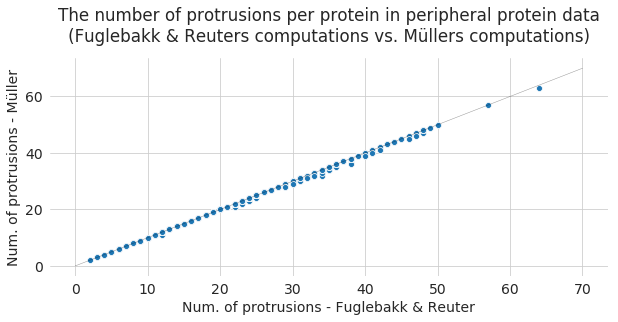

In [122]:
plt.figure(figsize=(10, 4))

font = {'family': 'normal', 'weight': 'normal', 'size': 14}
plt.rc('font', **font)

sns.set_style("whitegrid")
sns.scatterplot(x="edv_num_protr", y="flo_num_protr", data=diff_protrusions_periph)

plt.plot([0,70], [0,70], color="black", alpha=0.4, linewidth=0.5)

sns.despine(left=True, bottom=True)

plt.title(u"The number of protrusions per protein in peripheral protein data\n(Fuglebakk & Reuters computations vs. Müllers computations)", y=1.05)
plt.xlabel("Num. of protrusions - Fuglebakk & Reuter")
plt.ylabel(u'Num. of protrusions - Müller')

#plt.show()
plt.savefig("../results_and_feature_datasets/num_of_protrusions_periph2.png", dpi=120, bbox_inches='tight')

In [114]:
# compute R2 value
x = diff_protrusions_periph["edv_num_protr"]
y = diff_protrusions_periph["flo_num_protr"]
correlation_matrix = np.corrcoef(y, x)
correlation_xy = correlation_matrix[0,1]
print "R2 value periph: " + str(correlation_xy**2)

x = diff_protrusions_tm["edv_num_protr"]
y = diff_protrusions_tm["flo_num_protr"]
correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
print "R2 value tm: " + str(correlation_xy**2)

R2 value periph: 0.9995951927550007
R2 value tm: 0.994589692269172


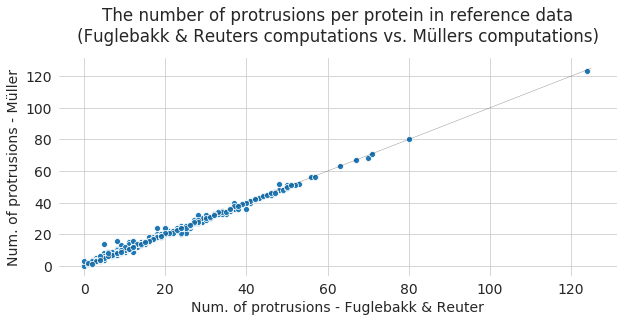

In [121]:
plt.figure(figsize=(10, 4))

font = {'family': 'normal', 'weight': 'normal', 'size': 14}
plt.rc('font', **font)

sns.set_style("whitegrid")
sns.scatterplot(x="edv_num_protr", y="flo_num_protr", data=diff_protrusions_tm)

plt.plot([0,125], [0,125], color="black", alpha=0.4, linewidth=0.5)

sns.despine(left=True, bottom=True)

plt.title(u"The number of protrusions per protein in reference data\n(Fuglebakk & Reuters computations vs. Müllers computations)", y=1.05)
plt.xlabel("Num. of protrusions - Fuglebakk & Reuter")
plt.ylabel(u'Num. of protrusions - Müller')

#plt.show()
plt.savefig("../results_and_feature_datasets/num_of_protrusions_tm2.png", dpi=120, bbox_inches='tight')

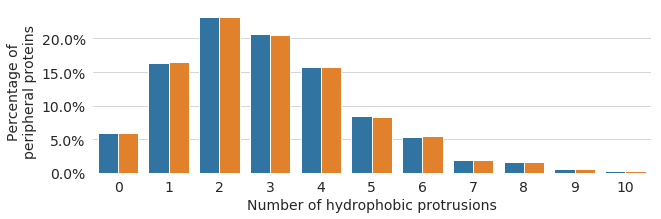

In [14]:
dd = diff_protrusions_periph["edv_num_hydr_protr"].value_counts(normalize = True).mul(100)
dd = dd.reset_index().sort_values("index")
dd.columns = ["index", "values"]
dd["dataset"] = "Fuglebakk & Reuter"

dd2 = diff_protrusions_periph["flo_num_hydr_protr"].value_counts(normalize = True).mul(100)
dd2 = dd2.reset_index().sort_values("index")
dd2.columns = ["index", "values"]
dd2["dataset"] = u"Müller"


plt.figure(figsize=(10, 3))

font = {'family': 'normal', 'weight': 'normal', 'size': 14}
plt.rc('font', **font)

sns.set_style("whitegrid")
sns.barplot(x="index", y="values", hue="dataset", data=dd.append(dd2))
sns.despine(left=True, bottom=True)

#plt.title(u"The distribution about hydrophobic protrusions in peripheral protein data\n(Fuglebakk & Reuters computations vs. Müllers computations)",
#          y=1.1)
plt.xlabel("Number of hydrophobic protrusions")
plt.ylabel("Percentage of\nperipheral proteins")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
#lgd = plt.legend(bbox_to_anchor=(0.5, 1.05), loc="center", borderaxespad=0, ncol=2, frameon=False)
plt.legend().remove()

plt.savefig("../results_and_feature_datasets/comparing_protr_edvin_and_florian/distribution_hydr_protrusions_periph.png", dpi=120, bbox_inches='tight')
#plt.show()

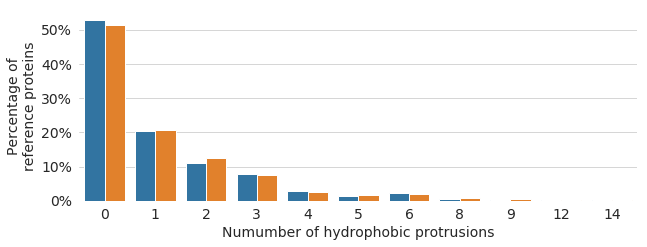

In [17]:
ddd = diff_protrusions_tm["edv_num_hydr_protr"].value_counts(normalize = True).mul(100)
ddd = ddd.reset_index().sort_values("index")
ddd.columns = ["index", "values"]
ddd["dataset"] = "Fuglebakk & Reuter"

ddd2 = diff_protrusions_tm["flo_num_hydr_protr"].value_counts(normalize = True).mul(100)
ddd2 = ddd2.reset_index().sort_values("index")
ddd2.columns = ["index", "values"]
ddd2["dataset"] = u"Müller"


plt.figure(figsize=(10, 3.5))

font = {'family': 'normal', 'weight': 'normal', 'size': 14}
plt.rc('font', **font)

sns.set_style("whitegrid")
sns.barplot(x="index", y="values", hue="dataset", data=ddd.append(ddd2))
sns.despine(left=True, bottom=True)

#plt.title(u"The distribution about hydrophobic protrusions in reference data\n(Fuglebakk & Reuters computations vs. Müllers computations)",
#          y=1.1)
plt.xlabel("Numumber of hydrophobic protrusions")
plt.ylabel("Percentage of\nreference proteins")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
#lgd = plt.legend(bbox_to_anchor=(0.5, 1.05), loc="center", borderaxespad=0, ncol=2, frameon=False)
plt.legend().remove()

plt.savefig("../results_and_feature_datasets/comparing_protr_edvin_and_florian/distribution_hydr_protrusions_tm.png", dpi=120, bbox_inches='tight')
#plt.show()

In [126]:
# compute R2 value
x = diff_protrusions_periph["edv_num_hydr_protr"]
y = diff_protrusions_periph["flo_num_hydr_protr"]
correlation_matrix = np.corrcoef(y, x)
correlation_xy = correlation_matrix[0,1]
print "R2 value periph: " + str(correlation_xy**2)

x = diff_protrusions_tm["edv_num_protr"]
y = diff_protrusions_tm["flo_num_protr"]
correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
print "R2 value tm: " + str(correlation_xy**2)

R2 value periph: 0.9985801326543795
R2 value tm: 0.994589692269172


### 5) Other stuff

The cells below are other stuff I checked and random thoughts I may want to remember.

In [127]:
edv_tm_data.query("structure == '1okc'").query("convhull == 1").sort_values(by=["resid", "chain"]) #.query("neighbours < 22")

facet_neighbours_polar resid chain  exposed  clusterness  \
2365                      0   246     A        1     0.939394   

     facet_neighbours_ww_if  neighbours facet_neighbours   sc_assa  \
2365                      0          12                0  0.599133   

     facet_neighbours_ww_oct  insertion  convhull       y       x      z type  \
2365                       0     -1.648         1  0.8786  0.3746 -3.128  ALA   

     structure  
2365      1okc

In [126]:
tm_protrusion_data.query("is_protrusion == 1").query("pdb == '1okc'").sort_values(by=["residue_number", "chain_id"])

atom_name  atom_number chain_id  is_hydrophobic_protrusion  \
10985        CB          333        A                          0   
11162        CB         1897        A                          0   

       is_on_convhull  is_protrusion  neighbours   pdb residue_name  \
10985               1              1          11  1okc          GLU   
11162               1              1          12  1okc          ALA   

       residue_number  x_coord  y_coord  z_coord  
10985              47   -4.522  -12.142  -30.806  
11162             246    3.475    8.662  -32.767

In [ ]:
diff_protrusions_tm

<br>

manual analysis of one pdb - mainly transmembrane

In [93]:
pdb = PandasPdb().read_pdb("../opm_data/tm/3pox.pdb")
# dumTable = pdb.df["HETATM"].query("residue_name == 'DUM'")

In [37]:
len(dumTable.query("atom_name == 'N'"))

2185

In [94]:
atomTable = trim_and_filter_periph(pdb)

In [95]:
result = pd.DataFrame(findFeatures("3pox", atomTable))

In [96]:
len(result.query("is_protrusion == 1"))

32

In [102]:
result2 = trim_and_filter_protrusions_tm(pdb, result)

In [104]:
result2.query("is_protrusion == 1")

index atom_name  atom_number chain_id  is_hydrophobic_protrusion  \
9     203        CB         1867        A                          1   
17    275        CB         2484        A                          0   
36    567        CB         5727        C                          0   
56    859        CB         8939        B                          0   

    is_on_convhull  is_protrusion  neighbours   pdb residue_name  \
9                1              1          20  3pox          PHE   
17               1              1          15  3pox          ASP   
36               1              1          15  3pox          ASP   
56               1              1          15  3pox          ASP   

    residue_number  x_coord  y_coord  z_coord  
9              244   14.374   22.216   33.570  
17             321   22.905   27.890   29.460  
36             321  -34.491    5.880   30.001  
56             321   12.571  -34.101   29.210

In [67]:
edv_periph_data.query("neighbours < 22").query("convhull == 1").query("structure == '1kcm'").query("type in ['LEU', 'ILE', 'PHE', 'TYR', 'TRP', 'CYS', 'MET']")

facet_neighbours_polar resid chain  exposed  clusterness  \
32                       1    75     A        1     0.805263   
122                      0    76     A        1     0.736842   
148                      2    72     A        1     0.961905   
150                      0   204     A        1     0.977778   

    facet_neighbours_ww_if  neighbours facet_neighbours   sc_assa  \
32                       1          20                3  1.277065   
122                      2          19                2  1.053164   
148                      3          15                7  1.422942   
150                      2          10                6  1.835967   

    facet_neighbours_ww_oct  insertion  convhull       y       x       z type  \
32                        1     0.0905         1 -1.5621  1.3228 -1.4495  MET   
122                       2     0.2494         1 -1.5237  0.9767 -1.2906  LEU   
148                       3     0.3825         1 -1.1489  1.4891 -1.1575  PHE   
150                       2    -0.1613         1 -1.5405 -1.2684 -1.7013  TRP   

    structure  
32       1kcm  
122      1kcm  
148      1kcm  
150      1kcm

<br>
<br>
<br>

In [7]:
points = np.random.rand(30, 3)
hull = ConvexHull(points)

In [13]:
print hull.vertices

[ 0  2  5  7 13 15 16 17 18 19 20 22 23 25 26 27 28 29]


In [12]:
idx = 7
d = pd.DataFrame(hull.simplices, columns=["x","y","z"])
dd = d.query(" (x == " + str(idx) + " or y == " + str(idx) + " or z == " + str(idx) + ")")
dd

x   y  z
1   25   5  7
18   2   5  7
27  27   2  7
30  27  25  7

In [14]:
foo = np.unique(dd.values)
foo[foo != idx]

array([ 2,  5, 25, 27], dtype=int32)

In [219]:
co_insertable

array([134, 140, 142], dtype=int32)

In [211]:
sublist = hydr_prot[(hydr_prot["idx"] == row["idx"])]


atom_name  atom_number chain_id  co_insertable  idx  \
63        CB          557        A              1  134   

    is_hydrophobic_protrusion  is_on_convhull  is_protrusion  neighbours  \
63                          1               1              1          15   

     pdb residue_name  residue_number  x_coord  y_coord  z_coord  
63  1kcm          PHE              72   15.029   -10.64  -10.302

In [220]:
pd.DataFrame(result).query("is_hydrophobic_protrusion > 0")

atom_name  atom_number chain_id  co_insertable  idx  \
63         CB          557        A              1  134   
66         CB          586        A              1  140   
67         CB          594        A              1  142   
190        CB         1650        A              0  393   

     is_hydrophobic_protrusion  is_on_convhull  is_protrusion  neighbours  \
63                           1               1              1          15   
66                           1               1              1          20   
67                           1               1              1          19   
190                          1               1              1          10   

      pdb residue_name  residue_number  x_coord  y_coord  z_coord  
63   1kcm          PHE              72   15.029  -10.640  -10.302  
66   1kcm          MET              75   13.842  -15.813  -13.114  
67   1kcm          LEU              76    9.544  -13.861  -12.259  
190  1kcm          TRP             204  -11.997  -15.938  -15.749

In [221]:
pd.DataFrame(result).query("co_insertable > 0")

atom_name  atom_number chain_id  co_insertable  idx  \
63        CB          557        A              1  134   
66        CB          586        A              1  140   
67        CB          594        A              1  142   

    is_hydrophobic_protrusion  is_on_convhull  is_protrusion  neighbours  \
63                          1               1              1          15   
66                          1               1              1          20   
67                          1               1              1          19   

     pdb residue_name  residue_number  x_coord  y_coord  z_coord  
63  1kcm          PHE              72   15.029  -10.640  -10.302  
66  1kcm          MET              75   13.842  -15.813  -13.114  
67  1kcm          LEU              76    9.544  -13.861  -12.259

In [168]:
#distances = dist[134][uniques]
uniques = [x for x in uniques if dist[134][x] < DISTANCE]
uniques

[140, 142]

In [237]:
print len(periph_protrusion_data.query("is_hydrophobic_protrusion == 1"))
print len(periph_protrusion_data.query("is_co_insertable > 0"))
print float(len(periph_protrusion_data.query("is_co_insertable > 0"))) / float(len(periph_protrusion_data.query("is_hydrophobic_protrusion == 1"))) * 100

2992
836
27.9411764706


In [238]:
print len(tm_protrusion_data.query("is_hydrophobic_protrusion == 1"))
print len(tm_protrusion_data.query("is_co_insertable > 0"))
print float(len(tm_protrusion_data.query("is_co_insertable > 0"))) / float(len(tm_protrusion_data.query("is_hydrophobic_protrusion == 1"))) * 100

568
53
9.33098591549


In [154]:
# Identify all neighbours
neighbour_residues = [i for i,d in enumerate(dist[134]) if d < DISTANCE and d > 0]
neighbour_residues = atomTable.iloc[neighbour_residues][["residue_number", "chain_id", "residue_name"]].drop_duplicates()
neighbour_residues = neighbour_residues[neighbour_residues["residue_number"] != 72] #72 is the residue number
neighbour_residues

residue_number chain_id residue_name
127              69        A          VAL
129              70        A          PRO
131              71        A          THR
135              73        A          VAL
137              74        A          ARG
139              75        A          MET
141              76        A          LEU

In [140]:
diff_protrusions_periph.query("edv_num_protr != flo_num_protr").iloc[0:5]

edv_num_hydr_protr  edv_num_protr  flo_num_hydr_protr  flo_num_protr  \
23                    8             38                   8             37   
39                    4             24                   4             23   
83                    3             30                   2             29   
141                   1             34                   1             33   
150                   2             34                   2             32   

      pdb  
23   3j2s  
39   1rgx  
83   1b9x  
141  3bl8  
150  3myv

In [159]:
foo = periph_protrusion_data.query("is_on_convhull > 0 & pdb == '3j2s'")
ref = edv_periph_data.query("convhull > 0 & structure == '3j2s'")
ref["resid"] = pd.to_numeric(ref["resid"])
print "Diff: " + str(len(foo)) + ", " + str(len(ref))

Diff: 50, 51


/home/florian/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [156]:
fooId = foo["residue_number"].to_numpy()
ref.query("resid not in @fooId").iloc[0:5]

facet_neighbours_polar  resid chain  exposed  clusterness  \
4017                      0   2184     B        1     0.783626   

     facet_neighbours_ww_if  neighbours facet_neighbours   sc_assa  \
4017                      0          19                0  0.379139   

     facet_neighbours_ww_oct  insertion  convhull       y       x       z  \
4017                       0    -2.5467         1  1.2275  0.0366  4.0867   

     type structure  
4017  ALA      3j2s

In [157]:
foo.query("residue_number == 2184")

Empty DataFrame
Columns: [atom_name, atom_number, chain_id, idx, is_co_insertable, is_hydrophobic_protrusion, is_on_convhull, is_protrusion, neighbours, pdb, residue_name, residue_number, x_coord, y_coord, z_coord]
Index: []

In [158]:
2184 not in fooId

True

In [12]:
foo = trim_and_filter(extract_atom_table("../opm_data/periph/" + "1kcm" + ".pdb"))

In [15]:
foo[["record_name", "atom_number", "atom_name", "alt_loc", "residue_name", "residue_number", "chain_id", "residue_number", "x_coord", "y_coord", "z_coord", "occupancy"]].iloc[0:10]

record_name  atom_number atom_name alt_loc residue_name  residue_number  \
0        ATOM            2        CA                  VAL               2   
1        ATOM            5        CB                  VAL               2   
2        ATOM            9        CA                  LEU               3   
3        ATOM           12        CB                  LEU               3   
4        ATOM           17        CA                  LEU               4   
5        ATOM           20        CB                  LEU               4   
6        ATOM           25        CA                  LYS               5   
7        ATOM           28        CB                  LYS               5   
8        ATOM           34        CA                  GLU               6   
9        ATOM           37        CB                  GLU               6   

  chain_id  residue_number  x_coord  y_coord  z_coord  occupancy  
0        A               2  -13.477  -11.260  -29.389        1.0  
1        A               2  -13.497  -12.079  -30.699        1.0  
2        A               3  -13.972   -7.610  -30.162        1.0  
3        A               3  -13.593   -6.737  -28.971        1.0  
4        A               4  -13.818   -6.074  -33.659        1.0  
5        A               4  -14.452   -6.853  -34.824        1.0  
6        A               5  -13.525   -2.393  -34.479        1.0  
7        A               5  -13.254   -1.487  -33.268        1.0  
8        A               6  -12.396   -0.546  -37.586        1.0  
9        A               6  -13.166   -0.730  -38.893        1.0

In [20]:
np.isnan(tm_protrusion_data.iloc[16269]["l_limit"])

True